In [4]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from Pipeline.filtering import butter_bandpass_filter
from Pipeline.Cascade.Detection.optimization import optimize_and_evaluate, GridSearch
from Pipeline.evaluation import detection_report
from Pipeline.Cascade.Detection.detection_algorithms import ECODetector, USTEnergyDetector, HilbertDetector, ECDFOutlierCountDetector, MovingStdDetector, STALTADetector, SNRDetector

In [2]:
seed = 1
np.random.seed(seed)

In [19]:
def balanced_extraction(dataset_dir, class_dict):
    # retrieve the paths of each class
    folders_path = dataset_dir.split("*")[0]
    paths = []
    for key in class_dict.keys():
        paths.append(folders_path + key + '/')

    # find the lengths of each folder of each class
    lengths = []
    for path in paths:
        lengths.append(len(os.listdir(path)))

    # take the minimum of these lengths
    min_length = min(lengths)

    features = []
    labels = []
    keys = list(class_dict.keys())
    # randomly select min_length files from each folder and generate features and labels
    for i, path in enumerate(paths):
        files = os.listdir(path)
        files = np.random.choice(files, min_length, replace=False)
        for file in files:
            sample, sr = librosa.load(path+file, sr=44100)
            sample = butter_bandpass_filter(sample, 200, 20000, sr, 2)
            #sample = (sample - np.mean(sample)) / np.std(sample)
            features.append(sample)
            #labels.append(class_dict[keys[i]])
            if keys[i] == 'Background':
                labels.append(0)
            else:
                labels.append(1)

    return features, labels

In [20]:
# dataset_dir = '../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/unprocessed_dataset/**/*.wav'
# class_dict = {'clean': 0, 'infested': 1}

dataset_dir = '../../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav'
class_dict = {'Background': 0, 'Big mandibles': 1, 'Small mandibles': 2}

features, labels = balanced_extraction(dataset_dir, class_dict)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15)

In [10]:
# ECOD

train_signal, sr = librosa.load('../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/unprocessed_dataset/infested/TASCAM_195_20.wav', sr=44100)
train_signal = butter_bandpass_filter(train_signal, 200, 20000, sr, 2)

params = {'contamination': [0.000005, 0.000006, 0.000007, 0.000008, 0.000009, 0.00001, 0.00002, 0.00003]}

detector = ECODetector(train_signal)

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'contamination': 4e-06}
Best f1-score: 0.7899772209567198

Evaluation on the test set:
False alarm prob: 37.58%
Miss detection prob: 6.71%
Number of False Positives: 62
Number of False Negatives: 11
Detector f1-score is 80.738786%

Other Metrics:
Detector accuracy is 77.811550%
Detector precision is 71.162791%
Detector recall is 93.292683%


In [16]:
# USTED: mean noise threshold

ref_noise = '../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/original_dataset/clean log/TASCAM_2.wav'
ref_noise, sampling_rate = librosa.load(ref_noise, sr=44100)
ref_noise = butter_bandpass_filter(ref_noise, 200, 20000, sampling_rate, 2)

params = {'frame_length': [50, 100, 200, 300, 400, 450],
          'hop_length': [50, 100, 120, 150],
          'factor': [1, 1.25, 1.5, 1.75, 2]}

detector = USTEnergyDetector(ref_noise, version='mean_noise_thresh')

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'frame_length': 300, 'hop_length': 150, 'factor': 1.5}
Best f1-score: 0.9532317393589069

Evaluation on the test set:
False alarm prob: 4.24%
Miss detection prob: 4.88%
Number of False Positives: 7
Number of False Negatives: 8
Detector f1-score is 95.412844%

Other Metrics:
Detector accuracy is 95.440729%
Detector precision is 95.705521%
Detector recall is 95.121951%


In [12]:
# USTED: noise distance threshold

ref_noise = '../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/original_dataset/clean log/TASCAM_2.wav'
ref_noise, sampling_rate = librosa.load(ref_noise, sr=44100)
ref_noise = butter_bandpass_filter(ref_noise, 200, 20000, sampling_rate, 2)

params = {'frame_length': [50, 100, 200, 300, 400, 450],
          'hop_length': [50, 100, 120, 150],
          'factor': [6, 7, 8, 9, 10]}

detector = USTEnergyDetector(ref_noise, version='noise_distance')

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'frame_length': 100, 'hop_length': 50, 'factor': 6}
Best f1-score: 0.9520732364028003

Evaluation on the test set:
False alarm prob: 2.42%
Miss detection prob: 6.71%
Number of False Positives: 4
Number of False Negatives: 11
Detector f1-score is 95.327103%

Other Metrics:
Detector accuracy is 95.440729%
Detector precision is 97.452229%
Detector recall is 93.292683%


In [48]:
# Hilbert detector

params = {'factor': [7.6, 7.7, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4]}

detector = HilbertDetector()

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'factor': 7.8}
Best f1-score: 0.8267622461170848

Evaluation on the test set:
False alarm prob: 7.88%
Miss detection prob: 29.27%
Number of False Positives: 13
Number of False Negatives: 48
Detector f1-score is 79.180887%

Other Metrics:
Detector accuracy is 81.458967%
Detector precision is 89.922481%
Detector recall is 70.731707%


In [14]:
# ECDF + Outlier Count

ref_noise = '../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/original_dataset/clean log/TASCAM_2.wav'
ref_noise, sampling_rate = librosa.load(ref_noise, sr=44100)
ref_noise = butter_bandpass_filter(ref_noise, 200, 20000, sampling_rate, 2)

params = {'pfa': [0.1, 0.01, 0.001, 0.0001],
          'outliers_count': [30, 40, 50, 100, 150]}

detector = ECDFOutlierCountDetector(ref_noise)

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'pfa': 0.01, 'outliers_count': 40}
Best f1-score: 0.9210381004969631

Evaluation on the test set:
False alarm prob: 2.42%
Miss detection prob: 12.2%
Number of False Positives: 4
Number of False Negatives: 20
Detector f1-score is 92.307692%

Other Metrics:
Detector accuracy is 92.705167%
Detector precision is 97.297297%
Detector recall is 87.804878%


In [13]:
# Moving Standard Deviation Detector: Adaptive

params = {'window_size': [300, 400, 450, 500, 550, 600],
          'grace_period': [30, 100],
          'factor': [5, 5.5, 6, 6.5, 7]}

detector = MovingStdDetector(version='adaptive')

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'window_size': 600, 'grace_period': 30, 'factor': 6}
Best f1-score: 0.7332185886402754

Evaluation on the test set:
False alarm prob: 18.18%
Miss detection prob: 33.54%
Number of False Positives: 30
Number of False Negatives: 55
Detector f1-score is 71.947195%

Other Metrics:
Detector accuracy is 74.164134%
Detector precision is 78.417266%
Detector recall is 66.463415%


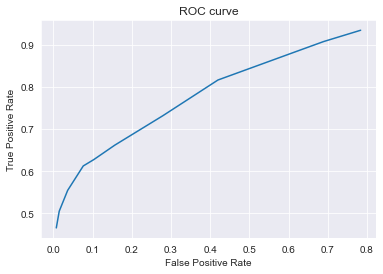

Best params: {'window_size': 500, 'grace_period': 30, 'factor': 7}

Evaluation on the test set:
False alarm prob: 1.82%
Miss detection prob: 48.78%
Number of False Positives: 3
Number of False Negatives: 80
Detector f1-score is 66.932271%

Other Metrics:
Detector accuracy is 74.772036%
Detector precision is 96.551724%
Detector recall is 51.219512%


In [11]:
params = {
    'window_size': [500],
    'grace_period': [30],
    'factor': [5, 5.15, 5.25, 5.5, 5.75, 6, 6.15, 6.25, 6.5, 6.75, 7]
    }

detector = MovingStdDetector(version='adaptive')

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.01, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

In [7]:
# Moving Standard Deviation Detector: Fixed

params = {'window_size': [50, 100, 200, 300, 400, 450, 500],
          'grace_period': [30, 100],
          'factor': [0.3, 0.4, 0.5, 0.6, 0.7]}

detector = MovingStdDetector(version='fixed')

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'window_size': 50, 'grace_period': 30, 'factor': 0.7}
Best f1-score: 0.823445318084346

Evaluation on the test set:
False alarm prob: 81.25%
Miss detection prob: 0.0%
Number of False Positives: 130
Number of False Negatives: 0
Detector f1-score is 81.994460%

Other Metrics:
Detector accuracy is 71.491228%
Detector precision is 69.483568%
Detector recall is 100.000000%


In [ ]:
params = {
    'window_size': [50],
    'grace_period': [30],
    'factor': [0.9, 1, 1.1, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36]
    }

detector = MovingStdDetector(version='fixed')

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.1, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

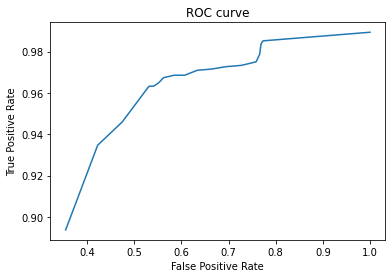

Best params: {'window_size': 50, 'grace_period': 30, 'factor': 0.0005}

Evaluation on the test set:
False alarm prob: 35.62%
Miss detection prob: 10.25%
Number of False Positives: 57
Number of False Negatives: 29
Detector f1-score is 85.521886%

Other Metrics:
Detector accuracy is 80.586907%
Detector precision is 81.672026%
Detector recall is 89.752650%


In [21]:
params = {
    'window_size': [50],
    'grace_period': [30],
    'factor': [0.0001, 0.0002, 0.00021, 0.00022, 0.000225, 0.00023, 0.000235, 0.00024, 0.000245, 0.00025, 0.000255, 0.00026, 0.000265, 0.00027, 0.000275, 0.00028, 0.000285, 0.00029, 0.000295, 0.0003, 0.00035, 0.0004, 0.0005]
    }

detector = MovingStdDetector(version='fixed')

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.01, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

In [14]:
# STA/LTA Detector

params = {'sta_win': [120, 140, 160, 180, 200],
          'lta_win': [400, 420, 440, 460, 480, 500],
          'threshold': [0.5, 0.55, 0.6, 0.65, 0.7]}

detector = STALTADetector()

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'sta_win': 200, 'lta_win': 420, 'threshold': 0.7}
Best f1-score: 0.7079741379310345

Evaluation on the test set:
False alarm prob: 30.91%
Miss detection prob: 32.93%
Number of False Positives: 51
Number of False Negatives: 54
Detector f1-score is 67.692308%

Other Metrics:
Detector accuracy is 68.085106%
Detector precision is 68.322981%
Detector recall is 67.073171%


In [13]:
# SNR Detector

ref_noise = '../../../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/unprocessed_dataset/clean/TASCAM_0_21.wav'
ref_noise, sr = librosa.load(ref_noise, sr=None)
ref_noise = butter_bandpass_filter(ref_noise, 200, 20000, sr, 2)

params = {'frame_length': [50, 100, 200, 300, 400, 450],
          'hop_length': [50, 100, 120, 150],
          'snr': [4, 5, 10, 15, 20]}

detector = SNRDetector(ref_noise)

_, _ = optimize_and_evaluate(detector, params, X_train, y_train, X_test, y_test)

Best params: {'frame_length': 300, 'hop_length': 100, 'snr': 5}
Best f1-score: 0.9435569755058573

Evaluation on the test set:
False alarm prob: 6.06%
Miss detection prob: 5.49%
Number of False Positives: 10
Number of False Negatives: 9
Detector f1-score is 94.224924%

Other Metrics:
Detector accuracy is 94.224924%
Detector precision is 93.939394%
Detector recall is 94.512195%


# CNN

In [25]:
import tensorflow as tf
from Pipeline.tf_dataset_builder import DatasetBuilder
from Pipeline.preprocess import SpectrogramExtractor, FrequencySelector

In [26]:
tf.random.set_seed(seed)

In [27]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
class_weight = {0: 1.0, 1: 1.0}
patience = 15

In [28]:
def extract_features(data, sample_rate=44100, nfft=128, win_length=128, hop_length=96, min_freq=500, max_freq=14000):
    features = []
    for signal in data:
        spectrogram_extractor = SpectrogramExtractor(nfft, win_length, hop_length, mode="spectrogram")
        selector = FrequencySelector(min_freq, max_freq)

        spectrogram = spectrogram_extractor.extract(signal, sample_rate, log=True).astype(np.float32)
        spectrogram, _ = selector.select(spectrogram, nfft, sample_rate)

        features.append(spectrogram)

    return  features

In [29]:
features_train = extract_features(X_train)
features_test = extract_features(X_test)
features_test = np.expand_dims(features_test, axis=-1).astype(np.float32)

In [30]:
features_train, features_val, y_train, y_val = train_test_split(features_train, y_train, test_size=0.15)

dataset_builder = DatasetBuilder(batch_size=batch_size)
train_ds = dataset_builder.build_dataset(features_train, y_train)
valid_ds = dataset_builder.build_dataset(features_val, y_val)

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(39, 45, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 45, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 23, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 23, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 12, 8)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 12, 8)         0         
                                                                 
 flatten (Flatten)           (None, 960)               0

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [33]:
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    class_weight=class_weight,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=patience),
)

Epoch 1/100
25/25 [==============================] - 1s 21ms/step - loss: 4.3483 - accuracy: 0.4877 - val_loss: 0.7840 - val_accuracy: 0.5286
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 1.3740 - accuracy: 0.5022 - val_loss: 0.7468 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 0.8085 - accuracy: 0.4991 - val_loss: 0.7059 - val_accuracy: 0.5036
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 0.7247 - accuracy: 0.5060 - val_loss: 0.7020 - val_accuracy: 0.4786
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 0.7031 - accuracy: 0.5287 - val_loss: 0.6986 - val_accuracy: 0.4964
Epoch 6/100
25/25 [==============================] - 0s 18ms/step - loss: 0.6940 - accuracy: 0.5148 - val_loss: 0.6954 - val_accuracy: 0.5036
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 0.6899 - accuracy: 0.5287 - val_loss: 0.6837 - val_accuracy: 0.5357
Epoch 

In [56]:
# Evaluate the model
predictions = model.predict(features_test)
y_pred = np.squeeze(np.rint(predictions), axis=-1)

detection_report(y_test, y_pred)

11/11 [==============================] - 0s 6ms/step

Evaluation on the test set:
False alarm prob: 6.06%
Miss detection prob: 10.98%
Number of False Positives: 10
Number of False Negatives: 18
Detector f1-score is 91.250000%

Other Metrics:
Detector accuracy is 91.489362%
Detector precision is 93.589744%
Detector recall is 89.024390%
